# Crime Pattern Analysis in Los Angeles (2024)

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import folium
from folium.plugins import HeatMap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, roc_auc_score
from folium.plugins import HeatMapWithTime
from IPython.display import display
from sklearn.linear_model import LogisticRegression
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings


In [ ]:
# Read the complete data
file_path = 'Crime_2024_with_Weather_Unemp_Monthly.xlsx'
df_interactive = pd.read_excel('Crime_2024_with_Weather_Unemp_Monthly.xlsx')


# Just add a request line, accelerated reading
usecols = [
    'date_of_occurrence', 'time_of_occurrence', 'area_name', 'crime_code_description',
    'victim_age', 'daily_precipitation_mm', 'daily_avg_temperature_celsius',
    'unemployment_rate_pct'
]

df = pd.read_excel(file_path, sheet_name='Sheet1', usecols=usecols)

# Change date format
df['date_of_occurrence'] = pd.to_datetime(df['date_of_occurrence'])
df['month'] = df['date_of_occurrence'].dt.to_period('M')

# No longer effective
df_valid_age = df[df['victim_age'] > 0]


In [ ]:
# Get message (ensure the path is correct)
df = pd.read_excel('Crime_2024_with_Weather_Unemp_Monthly.xlsx')

# Unified format
sns.set_theme(style='whitegrid')

# Time standardization
df['date_of_occurrence'] = pd.to_datetime(df['date_of_occurrence'], errors='coerce')
df['month'] = df['date_of_occurrence'].dt.month

##  1. Data source, format, and content

The primary dataset used in this project was obtained from the U.S. Government’s open data portal, specifically the “Crime Data from 2020 to Present” collection provided by the Los Angeles Police Department (LAPD). This dataset record all reported crime incidents that occurred from 2020 to present.

The data is structured as a flat table in CSV format, containing 1,005,200 rows (including the header) and 28 columns. Each row represents a unique crime report. The columns include details such as:
- Incident number (DR_NO), reporting and occurrence dates (Date Rptd, DATE OCC), and time (TIME OCC)
- Location information including area codes, reporting district, latitude and longitude
- Crime classification codes and descriptions (Crm Cd, Crm Cd Desc)
- Victim information such as age, gender, and ethnicity
- Weapon and premise details
- Case status and administrative codes

The dataset is updated daily by the LAPD and is openly accessible to the public. It provides a rich view of crime trends and characteristics in Los Angeles, which makes it suitable for exploratory and statistical analysis.

## 2. Data Retrieval

The crime data was manually downloaded from here: https://catalog.data.gov/dataset/crime-data-from-2020-to-present. The dataset is maintained by the Los Angeles Police Department and made publicly available in CSV format.

We downloaded the full dataset and then filtered it to include only crime incidents that occurred during the 2024 calendar year. After filtering, the data was saved and processed locally as an Excel file (Crime_2024_with_Weather_Unemp_Monthly.xlsx) for further cleaning and integration with weather and economic data.

## 3. Data Cleaning and Transformation

After retrieving the datasets, several cleaning and transformation steps were applied to prepare a tidy, analysis-ready dataframe:

- **Drop unnecessary columns**  
   A number of administrative or redundant fields were removed, including alternate crime codes (`Crm Cd 1–4`), raw ID columns (`DR_NO`, `Mocodes`), and derived fields not used in analysis.

- **Standardize column names**  
   The original column names were long and inconsistent, such as `TIME OCC` and `Vict Descent`. These were renamed into clear, lowercase snake_case format (e.g., `time_of_occurrence`, `victim_descent_code`) to improve readability and code maintainability.

- **Encode categorical features**  
   Victim sex and descent were originally coded as single-letter abbreviations (`M`, `F`, `W`, `H`, etc.). These were mapped to numeric codes to facilitate statistical analysis and machine learning:
   - Victim sex: `M → 0`, `F → 1`, `H → 2`, unknowns mapped to `None`
   - Victim descent: mapped to integers by group (e.g., `W → 0`, `B → 1`, `H → 2`, etc.), with unknowns excluded.

- **Handle missing values in victim age**  
   Missing values in `victim_age` were filled using a two-step strategy:  
   - First, fill with the mean victim age **within the same crime type**  
   - Then, for remaining missing values, fill with the **overall mean age**  
   This reduced all null values to zero, resulting in a fully populated column.

- **Add derived time-based features**  
   From the `date_of_occurrence` and `time_of_occurrence` fields, new variables such as `month`, `day_of_week`, and `hour` were generated for later time-based trend analysis.

The final dataset was a clean, tidy table with consistent naming, properly formatted columns, and minimal missing values—ready for analysis and visualization.

## 4.  Data Enrichment

To enhance the dataset, we added external information from two sources:  

- **Climate Data:**  
    We retrieved historical weather data from the Open-Meteo API based on the latitude and longitude of each grid point. For each date-location pair, we calculated average temperature by combining daily maximum and minimum temperatures, and also included total daily precipitation.

- **Unemployment Rate:**  

    We used the U.S. Bureau of Labor Statistics API to collect monthly county-level unemployment rates. Using reverse geocoding and FIPS codes, we matched each geographic grid cell to the appropriate county and merged in the unemployment data by year and month.

The final dataset includes daily crime records enriched with contextual climate and socioeconomic variables, allowing for more robust analysis of external influences on crime patterns.

## 5. Data Validation

To ensure the integrity of the enriched dataset, we used `pytest` to perform a series of automated quality checks. The tests covered several key areas:

- **Missing or Invalid Values**  
   Checked that critical fields (e.g., victim age, sex, and crime descriptions) are present and cleaned properly, with values falling within expected categories or ranges.

- **Geographic Validity**  
   Verified that latitude and longitude coordinates fall within the expected boundaries of Los Angeles.

- **Coded Variables**  
   Confirmed that categorical variables like victim sex and descent codes use only valid numerical codes.

- **Enriched Data Ranges**  
   Ensured that added features—such as unemployment rates, average temperatures, and precipitation levels—stay within realistic and interpretable bounds.


All tests passed successfully, giving us confidence in the consistency and reliability of the data before further analysis.

## 6 Area crime visualization

We visualize the spatial and temporal distribution of crimes across Los Angeles using a time-based heatmap. First, we filter the dataset to include only records with valid latitude and longitude values. For each month, we extract up to 5,000 random crime locations to avoid overcrowding the map. These monthly subsets are compiled into a list of coordinates required by `folium`'s `HeatMapWithTime`. We then generate an interactive map centered on Los Angeles, which displays a dynamic heatmap that animates month by month throughout 2024. This visualization highlights how crime density varies spatially and evolves over time. We can clearly observe that crime are concentrated at Central LA, Northwest LA, Santa Monica and Long Beach areas.


In [26]:

# Only keep data with latitude and longitude
df = df.dropna(subset=['latitude', 'longitude'])

# Organize data into the format required by HeatMap
heat_data_by_month = []
months = sorted(df['month'].unique())

for month in months:
    monthly_data = df[df['month'] == month]
    
    # Sample, avoid too many points
    if monthly_data.shape[0] > 5000:
        monthly_data = monthly_data.sample(5000, random_state=42)
    
    month_coords = monthly_data[['latitude', 'longitude']].values.tolist()
    heat_data_by_month.append(month_coords)

# Create map  
la_map = folium.Map(location=[34.0522, -118.2437], zoom_start=11)

# Add time heatmap
HeatMapWithTime(
    heat_data_by_month,
    index=[f'2024-{m:02d}' for m in months],
    radius=8,
    auto_play=True,
    max_opacity=0.8
).add_to(la_map)

# Display map
display(la_map)


## 7. Data analysis

### (1) Top 10 Areas with Highest Number of Crimes

The bar plot shows the Top 10 areas with the most crimes. Central has the highest crime count, and crime numbers gradually decline across areas. Only the Top 10 areas are shown to focus on key regions. Central leads by a large margin with over 10,000 cases, followed by Southwest and Pacific. Areas like Van Nuys, Olympic, and Devonshire still appear in the top 10 but have significantly lower totals, around 5,700–5,900 crimes. This suggests a strong spatial concentration of crime, especially in downtown and coastal regions.

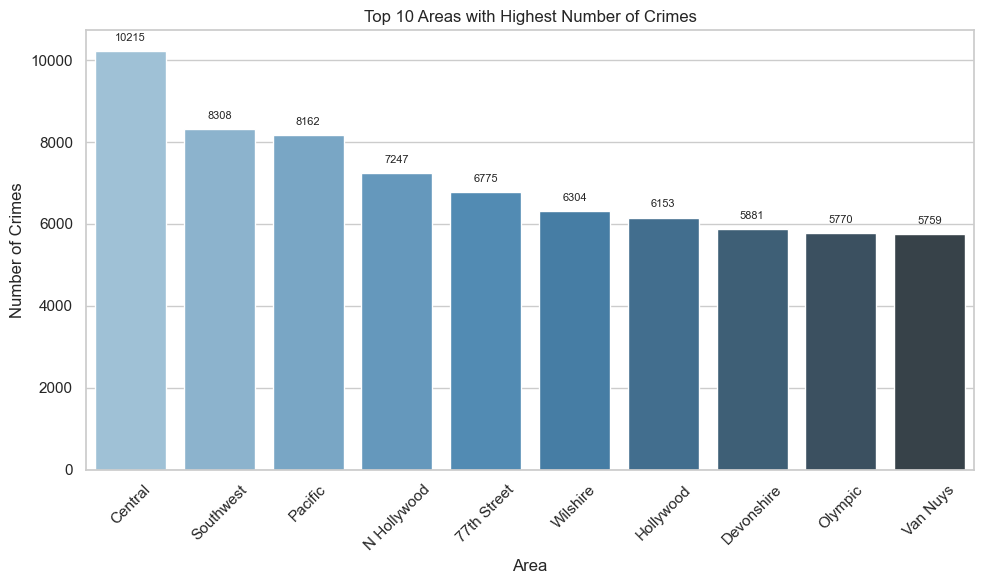

In [27]:
# Get top 10 areas by crime count
top_areas = df['area_name'].value_counts().head(10).reset_index()
top_areas.columns = ['Area', 'crime_count']

plt.figure(figsize=(10,6))
sns.barplot(data=top_areas, x='Area', y='crime_count', hue='Area', palette='Blues_d', legend=False)
plt.xticks(rotation=45)
plt.title('Top 10 Areas with Highest Number of Crimes')
plt.xlabel('Area')
plt.ylabel('Number of Crimes')

for i, value in enumerate(top_areas['crime_count']):
    plt.text(i, value + 200, f'{value}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### (2) 10 Major Crime Categories

The bar plot displays the Top 10 crime types in 2024. Vehicle theft is by far the most frequent crime, with over 21,000 cases, followed by burglary from vehicles and petty theft. Other frequent categories include Vandalism, Theft from Motor Vehicles, Theft of Identity, Grand Theft, and Trespassing.  
Therefore, property-related crimes, especially low-value theft and vehicle-related offenses, make up the majority of the top 10, highlighting their prominence in urban crime patterns.

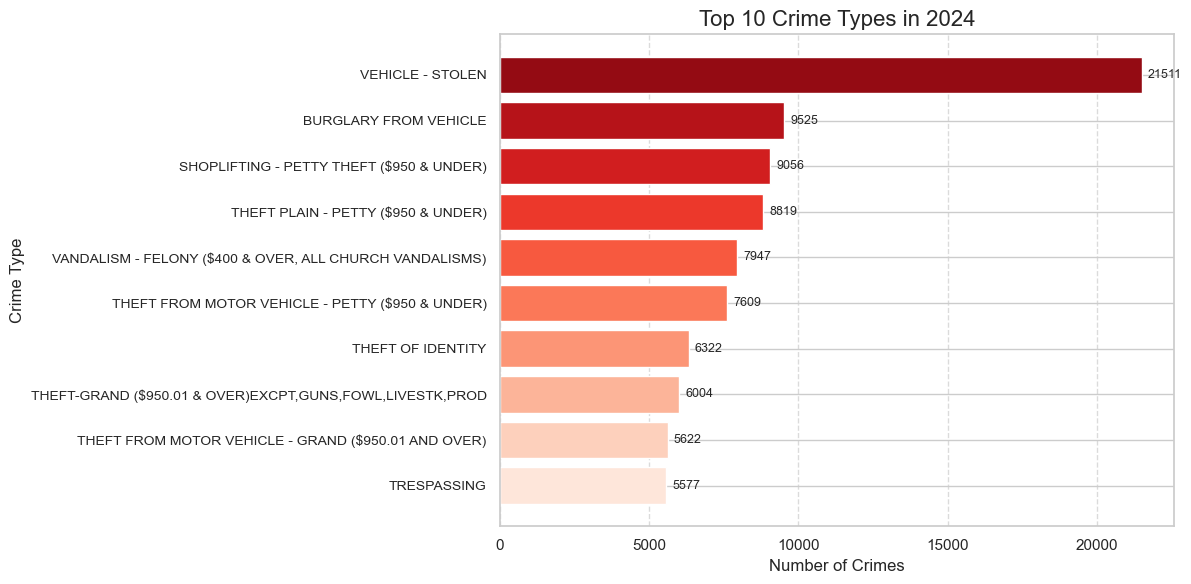

In [28]:
# [3. Distribution of the previous 10 major crime categories - strip pattern]
# Generate crime type quantity table
df_crime_type = df['crime_code_description'].value_counts().reset_index()
df_crime_type.columns = ['Crime Type', 'crime_count']

# Top 10
top_crimes = df_crime_type.sort_values('crime_count', ascending=False).head(10)

# plotting
fig, ax = plt.subplots(figsize=(12,6))
bars = ax.barh(y=top_crimes['Crime Type'], width=top_crimes['crime_count'], color=sns.color_palette('Reds_r', n_colors=10))
for bar in bars:
    width = bar.get_width()
    ax.text(width + 200, bar.get_y() + bar.get_height()/2,
            f'{int(width)}', va='center', fontsize=9)

ax.set_title('Top 10 Crime Types in 2024', fontsize=16)
ax.set_xlabel('Number of Crimes')
ax.set_ylabel('Crime Type')
plt.yticks(fontsize=10)
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### (3) Monthly Crime Quantity Calculation

The line plot shows monthly crime counts in Los Angeles for 2024.
A clear sharp decline starts after March, dropping from over 16,000 crimes to around 8,000 by June.
From June onward, crime levels remain relatively stable at a lower rate, with a slight drop again in December.
This pattern suggests a seasonal effect, with higher crime rates in early spring and much lower rates during summer and winter months.

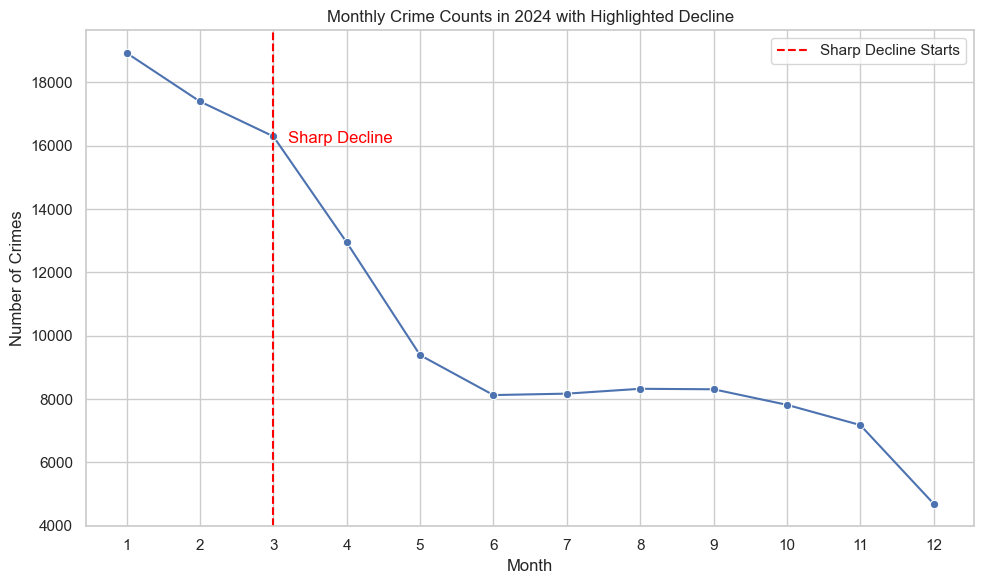

In [29]:
df_month = df.groupby('month').size().reset_index(name='crime_count')


plt.figure(figsize=(10,6))
sns.lineplot(data=df_month, x='month', y='crime_count', marker='o')
plt.xticks(ticks=range(1, 13))
plt.axvline(x=3, color='red', linestyle='--', label='Sharp Decline Starts')
plt.text(3.2, df_month['crime_count'].max()*0.85, 'Sharp Decline', color='red')
plt.title('Monthly Crime Counts in 2024 with Highlighted Decline')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### (4) Crime Type Distribution by Hour of Day

A stacked bar chart showing the number of misdemeanors and felonies by hour of the day. Crime counts increase throughout the day, peaking in late afternoon and evening.

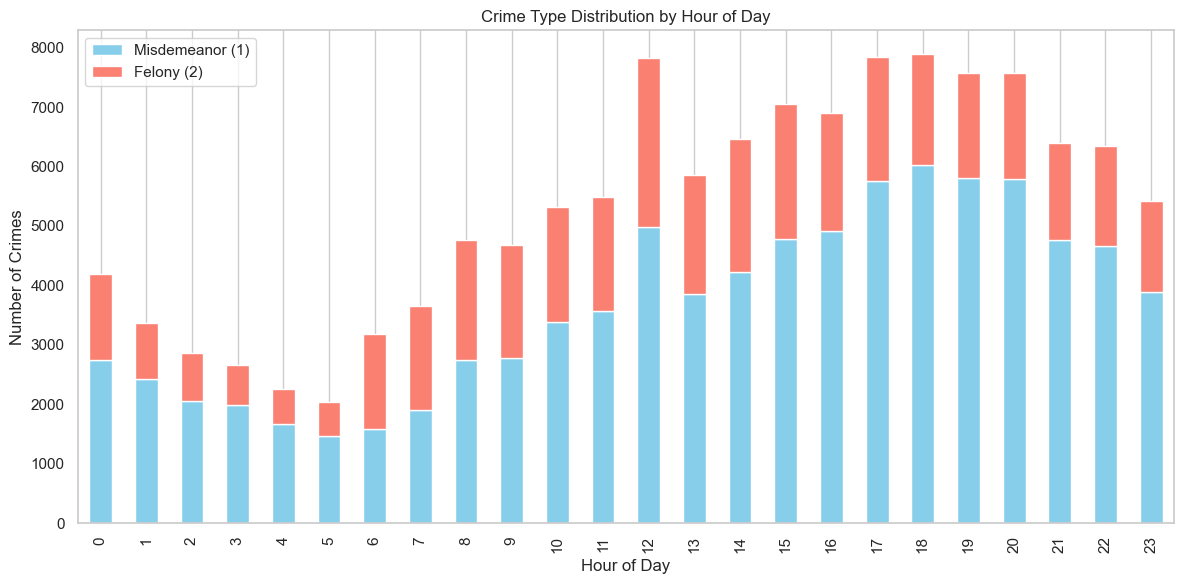

In [30]:
# [8. Small time vs. crime type change]
# Ensure 'hour' column exists
if 'hour' not in df.columns:
    def extract_hour(x):
        try:
            x_str = str(int(x)).zfill(4)
            return int(x_str[:2])
        except:
            return np.nan
    df['hour'] = df['time_of_occurrence'].apply(extract_hour)

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
df_hour = df[['hour', 'crime_part_category']].dropna()
df_hour['hour'] = df_hour['hour'].astype(int) 

# Amount of crime/felony amount
hour_crime_counts = df_hour.groupby(['hour', 'crime_part_category']).size().unstack(fill_value=0)

# Painted columnar diagram
hour_crime_counts.plot(kind='bar', stacked=True, figsize=(12,6), color=['skyblue', 'salmon'])
plt.title('Crime Type Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0,24))
plt.legend(['Misdemeanor (1)', 'Felony (2)'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### (5) Average Temperature vs. Daily Crime Amount

A scatter plot showing the relationship between average daily temperature and daily crime counts. Crime incidents generally decrease as temperatures rise. A red regression line highlights the negative trend. A note marks that there are no records below 8°C, ensuring accurate data interpretation.

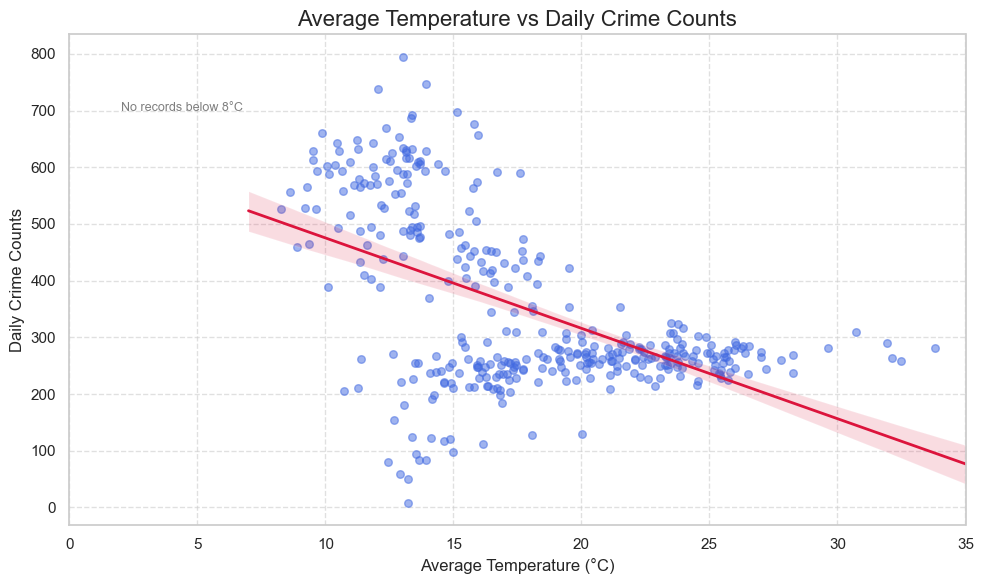

In [31]:
# [4. Average temperature vs. daily crime amount - scattered pictures + circular]
# Create a column with just the date for grouping
df['date_only'] = df['date_of_occurrence'].dt.date

# Group by date to count total crimes per day
daily_crime_counts = df.groupby('date_only').size().reset_index(name='crime_count')

# Group by date to get average temperature per day
daily_temp = df.groupby('date_only')['daily_avg_temperature_celsius'].mean().reset_index()

# Merge crime and temperature data on date
daily_data = pd.merge(daily_crime_counts, daily_temp, on='date_only')

# Plotting the relationship
plt.figure(figsize=(10, 6))

sns.regplot(
    data=daily_data,
    x='daily_avg_temperature_celsius',
    y='crime_count',
    scatter_kws={'alpha': 0.5, 's': 30, 'color': 'royalblue'},  
    line_kws={'color': 'crimson', 'linewidth': 2},   
    truncate=False                                      
)

# Customize appearance
plt.xlim(0, 35)
plt.title('Average Temperature vs Daily Crime Counts', fontsize=16)
plt.xlabel('Average Temperature (°C)', fontsize=12)
plt.ylabel('Daily Crime Counts', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional annotation for no-data region
plt.text(2, 700, 'No records below 8°C', color='gray', fontsize=9)

plt.tight_layout()
plt.show()

### (6) Weekend/Weekday Temperature vs Crime Quantity

This scatter plot compares the relationship between average temperature and daily crime counts on weekdays and weekends. Each point represents the total crime count for a given temperature. Different markers (circles and triangles) were used to distinguish weekdays and weekends more clearly. Regression lines show that crime rates are generally higher on weekdays, but both decrease as temperature rises.

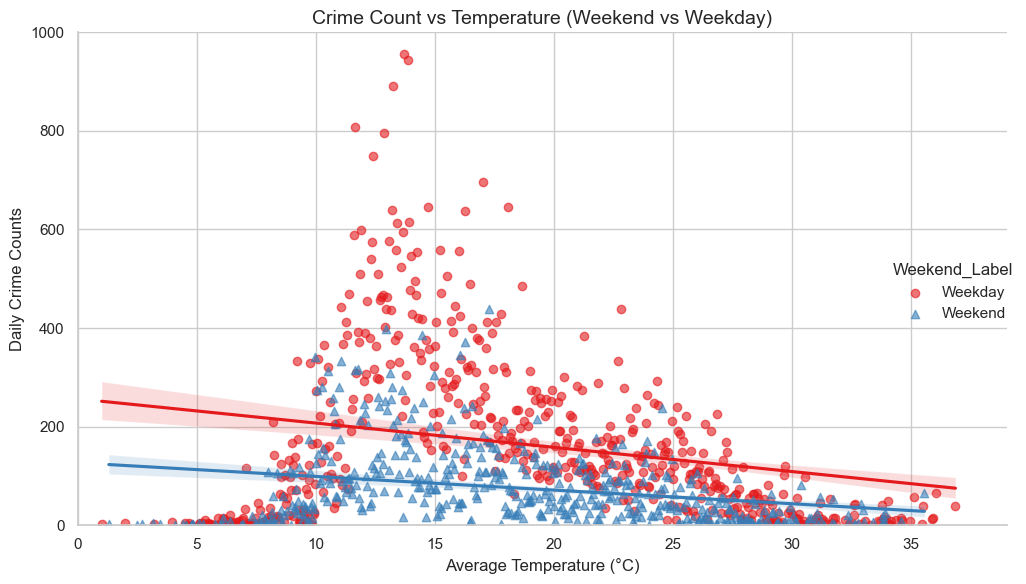

In [32]:
# [5. Weekend/Weekday Temperature vs Crime Quantity]
# Ensure 'is_weekend' exists
if 'is_weekend' not in df.columns:
    df['date_of_occurrence'] = pd.to_datetime(df['date_of_occurrence'], errors='coerce')
    df['dayofweek'] = df['date_of_occurrence'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Add a crime count column
df['crime_count'] = 1

# Group data by weekend status and temperature
grouped = df.groupby(['is_weekend', 'daily_avg_temperature_celsius']).agg({'crime_count':'sum'}).reset_index()

# Map 0/1 to clear labels
grouped['Weekend_Label'] = grouped['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

# Create a scatterplot with regression lines
sns.lmplot(
    data=grouped,
    x='daily_avg_temperature_celsius',
    y='crime_count',
    hue='Weekend_Label',
    palette='Set1',
    aspect=1.5,
    height=6,
    markers=['o', '^'],
    scatter_kws={'alpha':0.6}  
)

# Perfect customizations
plt.title('Crime Count vs Temperature (Weekend vs Weekday)', fontsize=14)
plt.xlabel('Average Temperature (°C)', fontsize=12)
plt.ylabel('Daily Crime Counts', fontsize=12)
plt.ylim(0, 1000)
plt.xlim(0, 39)  
plt.grid(True)
plt.tight_layout()
plt.show()

### (7) Unemployment Rate vs. Monthly Crime Volume

This plot examines the relationship between the unemployment rate and monthly crime counts. A slight negative trend is observed, suggesting that higher unemployment rates might be associated with lower crime counts. The regression line with a 95% confidence interval provides a statistical insight into the negative relationship.

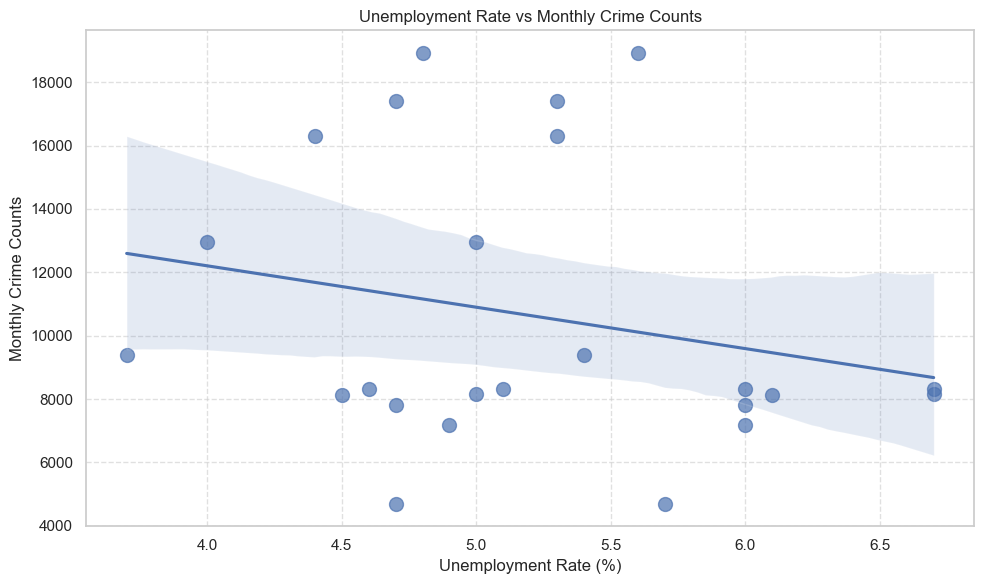

In [33]:
# [7. Business failure rate vs. monthly crime volume - scattered pictures + circular]
# Monthly loss rate (lost weight)
monthly_unemp = df[['month', 'unemployment_rate_pct']].drop_duplicates()

# Crime count per month
monthly_crimes = df.groupby('month').size().reset_index(name='crime_count')

# Merging
monthly_data = pd.merge(monthly_crimes, monthly_unemp, on='month')

plt.figure(figsize=(10, 6))
sns.regplot(x='unemployment_rate_pct', y='crime_count', data=monthly_data, scatter_kws={'alpha':0.7, 's':100})
plt.title('Unemployment Rate vs Monthly Crime Counts')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Monthly Crime Counts')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 8. Data Modeling

### (1) Data Pre-processing

We begin by preparing the target variable and extracting key features for our binary classification model. The response variable `crime_part_category` is recoded so that misdemeanors are labeled as 0 and felonies as 1. To capture temporal patterns in crime, we derive an `is_weekend` indicator from the `date_of_occurrence`, assigning a value of 1 if the crime occurred on a Saturday or Sunday, and 0 otherwise. In addition, we extract the hour component from the four-digit `time_of_occurrence` field to reflect the time of day when the crime took place. These transformations allow us to incorporate both calendar-based and time-of-day information into our model.

In [34]:
df = pd.read_excel('/Users/fuyanting/Documents/Data_Wrangling/Crime_2024_with_Weather_Unemp_Monthly.xlsx')

In [35]:
# --- y variable ---
y = df['crime_part_category']  
y = y.replace({1: 0, 2: 1}) # 0=misdemeanor, 1=felony

# Whether it's a weekend is_weekend
df['dayofweek'] = df['date_of_occurrence'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Extract hour
def extract_hour(x):
    try:
        x_str = str(int(x)).zfill(4)
        return int(x_str[:2])
    except:
        return np.nan

df['hour'] = df['time_of_occurrence'].apply(extract_hour)

### (2) One-hot Coding

We perform one-hot encoding on three categorical variables: `area_name`, `victim_sex`, and `victim_descent_code`, using `pd.get_dummies` with `drop_first=False` to preserve all category levels. In addition to the encoded categorical features, we include a set of numerical predictors: `month`, `is_weekend`, `hour`, `victim_age`, `daily_precipitation_mm`, `daily_avg_temperature_celsius`, and `unemployment_rate_pct`. We then construct the final feature matrix `X` by combining the numerical columns with the newly generated one-hot encoded columns extracted from the transformed dataframe. This matrix serves as the input for our classification model.

In [36]:
# Select the columns that need to be One-Hot
onehot_cols = ['area_name', 'victim_sex', 'victim_descent_code']

# One-Hot coding directly with get_dummies
df_onehot = pd.get_dummies(df, columns=onehot_cols, drop_first=False)

# Numerical Characteristics
numerical_cols = [
    'month', 'is_weekend', 'hour',
    'victim_age',
    'daily_precipitation_mm', 'daily_avg_temperature_celsius', 'unemployment_rate_pct'
]

# Finding One-Hot Columns from df_onehot
onehot_feature_cols = [col for col in df_onehot.columns if col.startswith('area_name_') 
                                                        or col.startswith('victim_sex_') 
                                                        or col.startswith('victim_descent_code_')]

# Merge all feature columns
feature_cols = numerical_cols + onehot_feature_cols

# Final X-matrix

X = df_onehot[feature_cols]
X = X.drop(columns=['victim_descent_code_new', 'victim_sex_new'])


### (3) Split Train and Test Set

We split the data into training and test sets using a 70/30 split. To ensure that the class distribution (i.e., felony vs. misdemeanor) remains consistent across both sets, we apply stratified sampling based on the target variable `y`. A fixed `random_state` is used for reproducibility.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### (4) Logistic Regression

We train a logistic regression model using the same feature set to predict whether a crime is a felony. After fitting the model on the training data, we evaluate its performance on the test set using accuracy, ROC AUC, precision, and recall. These metrics allow us to assess both the overall classification quality and the model’s ability to correctly identify serious crimes (felonies). The probabilistic output from the model is also used to generate the ROC curve for visual comparison with tree-based models.

In [38]:
warnings.filterwarnings("ignore")
# Logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))

Logistic regression:
Accuracy: 0.740828804347826
ROC AUC: 0.8212366206889112
Precision: 0.5915543900895198
Recall: 0.547722705961152


### (5) Random Forest & XGBoost

We train two classification models—Random Forest and XGBoost—to predict whether a given crime is a felony or a misdemeanor. Both models are trained using the same set of features and evaluated on the test set. For Random Forest, we use 100 trees with a fixed random seed. For XGBoost, we specify `logloss` as the evaluation metric to align with the binary classification objective.

To assess model performance, we report four standard classification metrics: **Accuracy**, **ROC AUC**, **Precision**, and **Recall**, focusing on the positive class (felony). These metrics help evaluate not only overall correctness but also the model’s ability to detect serious crimes.

In [39]:
# ----------------------------
# Random Forest
# ----------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# ----------------------------
# XGBoost
# ----------------------------
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# ----------------------------
# Evaluation
# ----------------------------
print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Precision:", precision_score(y_test, y_pred_rf, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_rf, pos_label=1))

print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_xgb, pos_label=1))

Random Forest:
Accuracy: 0.7999059364548495
ROC AUC: 0.8923927752814054
Precision: 0.6770196596728895
Recall: 0.6862022772940388

XGBoost:
Accuracy: 0.8171247909698997
ROC AUC: 0.9100901234908048
Precision: 0.6939367793552436
Recall: 0.7407066309444073


### (6) ROC Curve

The ROC curve compares the classification performance of three models: Random Forest, XGBoost, and Logistic Regression. Both Random Forest and XGBoost achieve an AUC of 0.85, indicating strong ability to distinguish between felonies and misdemeanors. Logistic Regression performs slightly lower, with an AUC of 0.82. Overall, tree-based models show a slight edge in predictive power, especially at lower false positive rates. The curves confirm that all models perform significantly better than random guessing.

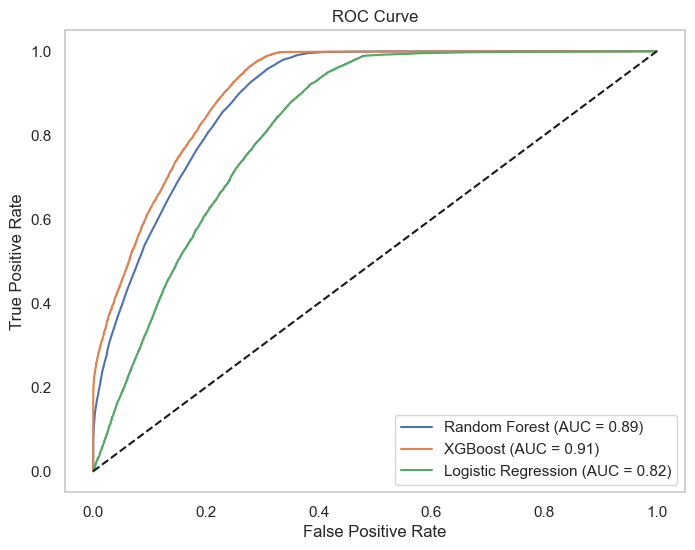

In [40]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf, pos_label=1)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb, pos_label=1)
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba, pos_label=1) 

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %.2f)' % auc(fpr_rf, tpr_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %.2f)' % auc(fpr_xgb, tpr_xgb))
plt.plot(fpr_log, tpr_log, label='Logistic Regression (AUC = %.2f)' % auc(fpr_log, tpr_log))
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


### (7) Precision-Recall curve

The precision-recall curve compares the performance of Random Forest, XGBoost, and Logistic Regression in identifying felonies. Both tree-based models maintain high precision at low recall levels, indicating strong performance in identifying the most confident felony predictions. In contrast, Logistic Regression starts with a sharp drop in precision at very low recall—an expected behavior when very few positive predictions are made early and one misclassification leads to zero precision. As recall increases, Logistic Regression shows a more stable precision-recall trade-off, while Random Forest and XGBoost gradually decline. Overall, the tree-based models outperform Logistic Regression across most recall levels, particularly in high-precision regions.

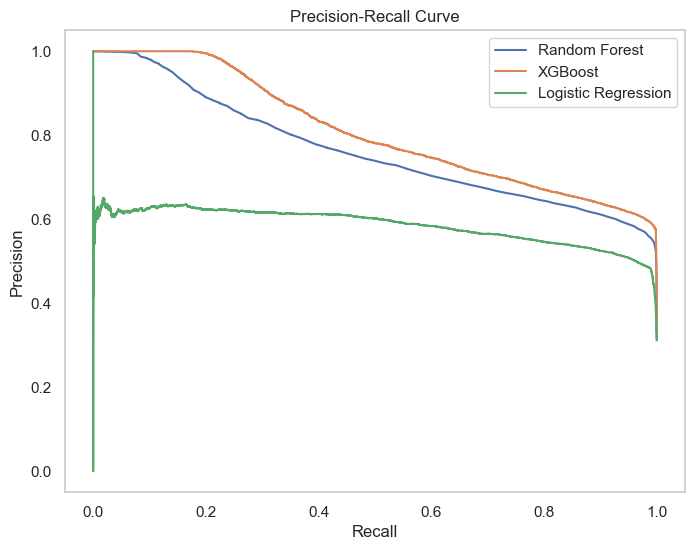

In [41]:
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf, pos_label=1)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb, pos_label=1)
prec_log, rec_log, _ = precision_recall_curve(y_test, y_proba, pos_label=1)  # Logistic regression

plt.figure(figsize=(8,6))
plt.plot(rec_rf, prec_rf, label='Random Forest')
plt.plot(rec_xgb, prec_xgb, label='XGBoost')
plt.plot(rec_log, prec_log, label='Logistic Regression')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

### (8) Feature Importance

The feature importance plot shows the top 15 predictors used by the Random Forest model to distinguish between felonies and misdemeanors. `victim_age` and `daily_avg_temperature_celsius` are the two most influential features, suggesting that both demographic and environmental factors significantly impact the likelihood of a crime being a felony. Time-related variables like `hour` and `month` also contribute meaningfully, indicating temporal patterns in serious crimes. Several victim-related characteristics—including sex and descent code—appear among the top features, highlighting the relevance of demographic factors. While socioeconomic indicators such as `unemployment_rate_pct` and `is_weekend` show lower importance, they still provide additional context in the model’s decision process.

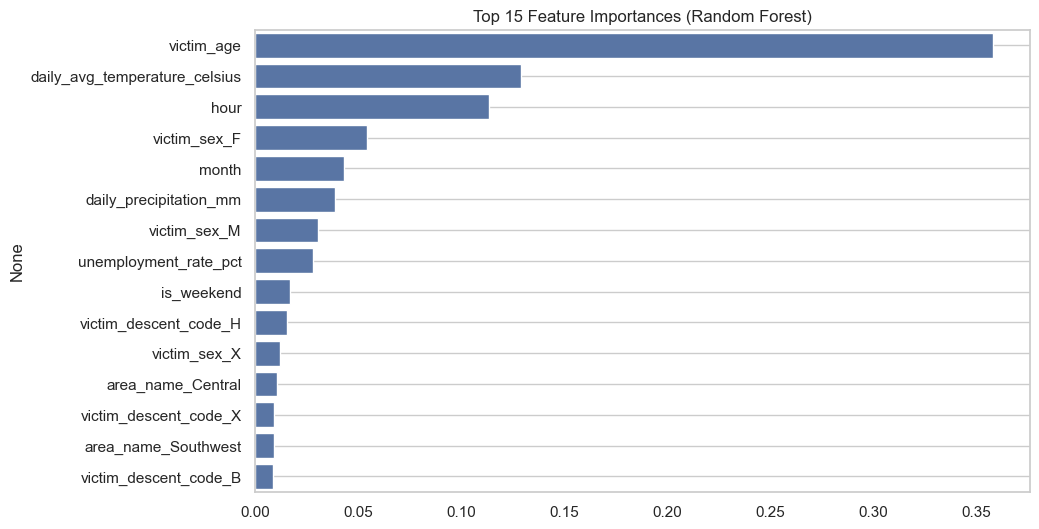

In [42]:
importances = rf_model.feature_importances_
feat_names = X.columns

feat_importances = pd.Series(importances, index=feat_names)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values[:15], y=feat_importances.index[:15])
plt.title('Top 15 Feature Importances (Random Forest)')
plt.grid()
plt.show()

## 9. Conclusion

Our analysis shows that crime in Los Angeles is spatially and temporally patterned. Central, Southwest, and Pacific are consistently high-crime areas. Theft-related offenses, especially vehicle theft, dominate the crime types. We observed a sharp monthly decline after March, with crime levels remaining low during summer and winter. Crimes tend to occur more often in the afternoon and early evening, and weekends see slightly higher counts than weekdays. Additionally, higher unemployment rates are associated with fewer reported crimes. These findings highlight the need to consider location, time, and social context in crime prevention strategies.  
In our modeling of crime severity classification, we compared logistic regression, random forest, and XGBoost. Among these, random forest performed the best in terms of accuracy and AUC. The most important features were victim age, average temperature, and hour of the day. These results suggest that crime severity is not only shaped by who the victim is, but also by when and under what conditions the crime occurs.   
Understanding these patterns can help law enforcement agencies optimize patrol timing and resource deployment, and support targeted interventions for vulnerable groups.

## 10. Git Commit History Graph


<p align="center">
  <img src="Git_Graph.jpg" width="600">
</p>